# Requirements for grid search algorithm:
1. Plot unit activations on 2d grid where 
    - X direction is MAGNITUDE OF ACTIVATION
    - Y direction is SELECTIVITY OF ACTIVATION
2. Partition in Y direction first so that each parcellation contains same number of units
3. Partition each strip in the X direction so that each box contains the same number of units
4. Lesion each box and compute MPPI score
5. Compute the RDS score for each box
6. Make 2 graphs:
    - One with colors corresponding to RDS score
    - Second with colors corresponding to MPPI score

# Imports

In [1]:
import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Change


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('tf')
from keras_applications import imagenet_utils as utils
from keras_applications import correct_pad
from keras.layers import Lambda

from scipy import stats
import PIL.Image
import seaborn as sns
import gc
# import innvestigate
# import innvestigate.utils
# from vis.utils import utils as vis_utils
from keras.preprocessing.image import load_img, img_to_array
#}

import geopandas 
import shapely
import pandas as pd
import rtree
import time
import glob
import math

from model_utils import *

Using TensorFlow backend.


In [2]:
debug = False
model_name = 'MobileNetV2'
data_path = '/Volumes/DATA/Graduate/Hirshfield/McKell/Cognitive-Parcellation/data/gridSearchFiles/'
classes = ['animate','inanimate']

# Data Loading

In [3]:
#Load the details of all the 1000 classes and the function to conver the synset id to words
meta_clsloc_file = data_path+'meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [4]:
#Code snippet to load the ground truth labels to measure the performance
truth = {}
with open(data_path+'ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1

# Grid Search

In [5]:
with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        animate_activations = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        inanimate_activations = pickle.load(f)

X = np.column_stack((animate_activations,inanimate_activations)) 

Average Activations for Animate and Inanimate 


In [6]:
X.shape

(5725552, 2)

In [7]:
X

array([[-5.27996942e-02, -2.32655811e-03],
       [-1.71267375e-01,  3.85377295e-02],
       [-7.69475941e-03,  2.92868316e-02],
       ...,
       [-7.12368059e+00, -7.94886589e+00],
       [-2.89974189e+00, -2.43613458e+00],
       [-7.55552101e+00, -7.20971823e+00]])

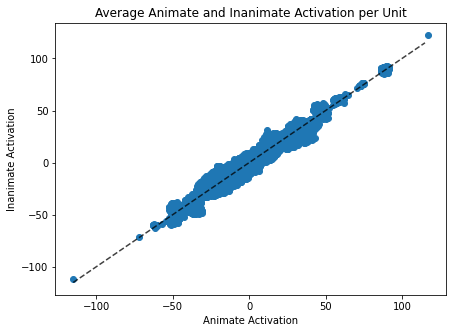

In [66]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.scatter(X[:,0],X[:,1])
ax.set_title('Average Animate and Inanimate Activation per Unit')
ax.set_xlabel('Animate Activation')
ax.set_ylabel('Inanimate Activation')
ax.plot([-115,115],[-115,115], 'k--', color='black', alpha=0.75) ## dotted --> k
fig.savefig(data_path+'figs/units_activation_space.png', dpi=200)

### We want to transform this space to get MAGNITUDE and SELECTIVITY

In [9]:
def activation_to_magnitude(coordinates):
    magnitude = np.sum(coordinates,axis=1)/np.sqrt(2)
    return magnitude 

def activation_to_selectivity(coordinates):
    selectivity = (coordinates[:,1] - coordinates[:,0])/np.sqrt(2)
    return selectivity

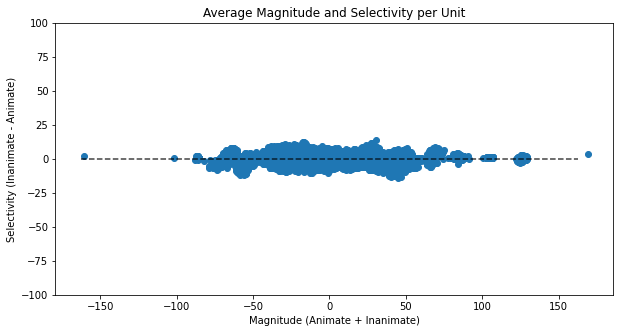

In [67]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(activation_to_magnitude(X),activation_to_selectivity(X))
ax.set_title('Average Magnitude and Selectivity per Unit')
ax.set_xlabel('Magnitude (Animate + Inanimate)')
ax.set_ylabel('Selectivity (Inanimate - Animate)')
ax.set_ylim((-100,100))
ax.plot([activation_to_magnitude(np.array([[-115,-115]])),activation_to_magnitude(np.array([[115,115]]))],
        [activation_to_selectivity(np.array([[-115,-115]])),activation_to_selectivity(np.array([[115,115]]))], 
        'k--', color='black', alpha=0.75) ## dotted --> k
fig.savefig(data_path+'figs/units_selectivity_magnitude_space.png', dpi=200)

In [11]:
def grid_space(x,y,y_partitions=28,x_partitions=28,symmetric=False):
    """
    Takes in set of coordinates in 2D space and returns geopandas.GeoDataFrame
    where each entry represents a single cell in the grid space with an equal number
    of units. Symmetric grids don't necessarily have the same number of units per cell.
    
    Parameters
    ----------
        x (1D list) : List of x coordinates
        y (1D list) : List of y coordinates
        y_partitions: Number of partitions in Y direction, should be even number so that
                      cells can be symmetrical around zero
        x_partitions: Number of partitions in X direction, should be even number so that
                      cells can be symmetrical around zero
        symmetric (bool): Whether or not to make it symmetric around zero
                      
    Returns
    -------
        geopandas.GeoDataFrame : one entry per cell in grid starting at bottom left and going right
        
    """
    if symmetric:
        y_neg_sorted = np.sort(y[y<0])
        y_pos_sorted = np.sort(y[y>0])

        # First half of bounds come from negative region, second from positive
        y_bounds = ([y_neg_sorted[int(((2*i)/y_partitions)*len(y_neg_sorted))] 
                         for i in range(int(y_partitions/2))] + [0] +
                    [y_pos_sorted[int(((2*i)/y_partitions)*len(y_pos_sorted))] 
                         for i in range(1,int(y_partitions/2))] + [y_pos_sorted[-1]])
    else:
        y_sorted = np.sort(y)
        y_bounds = ([y_sorted[math.floor((i/y_partitions)*len(y_sorted))] 
                         for i in range(y_partitions)] + [y_sorted[-1]])

    grid_cells = []
    
    for i,y_lower_bound in enumerate(y_bounds[:-1]):
        y_upper_bound = y_bounds[i+1]
        
        if symmetric:
            # Only look at x coordinates which fall within vertical (y direction) strip of interest
            x_neg_sorted = np.sort(x[(y > y_lower_bound) & (y < y_upper_bound) & (x < 0)])
            x_pos_sorted = np.sort(x[(y > y_lower_bound) & (y < y_upper_bound) & (x > 0)])

            # First half of bounds come from negative region, second from positive
            x_bounds = ([x_neg_sorted[int(((2*k)/x_partitions)*len(x_neg_sorted))] 
                             for k in range(int(x_partitions/2))] + [0] +
                        [x_pos_sorted[int(((2*k)/x_partitions)*len(x_pos_sorted))] 
                             for k in range(1,int(x_partitions/2))] + [x_pos_sorted[-1]])
        else:
            x_sorted = np.sort(x[(y > y_lower_bound) & (y < y_upper_bound)])
            x_bounds = ([x_sorted[int((k/x_partitions)*len(x_sorted))] 
                             for k in range(x_partitions)] + [x_sorted[-1]])
        
        # Add bounds to list
        for j,x_lower_bound in enumerate(x_bounds[:-1]):
            x_upper_bound = x_bounds[j+1]
            grid_cells.append(shapely.geometry.box(x_lower_bound, y_lower_bound, 
                                                   x_upper_bound, y_upper_bound))
    
    # I don't know what this CRS projection is...
    crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
    return geopandas.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

We want a grid with the following specifications: <br>

+ 5725552 UNITS <br>
+ 784 CELLS <br>
+ 28 X-PARTITIONS <br>
+ 28 Y-PARTITIONS <br>
+ 7303 UNITS PER CELL <br>

In [12]:
magnitude = activation_to_magnitude(X)
selectivity = activation_to_selectivity(X)

In [13]:
cell = grid_space(magnitude,selectivity)

In [14]:
print(len(cell))

784


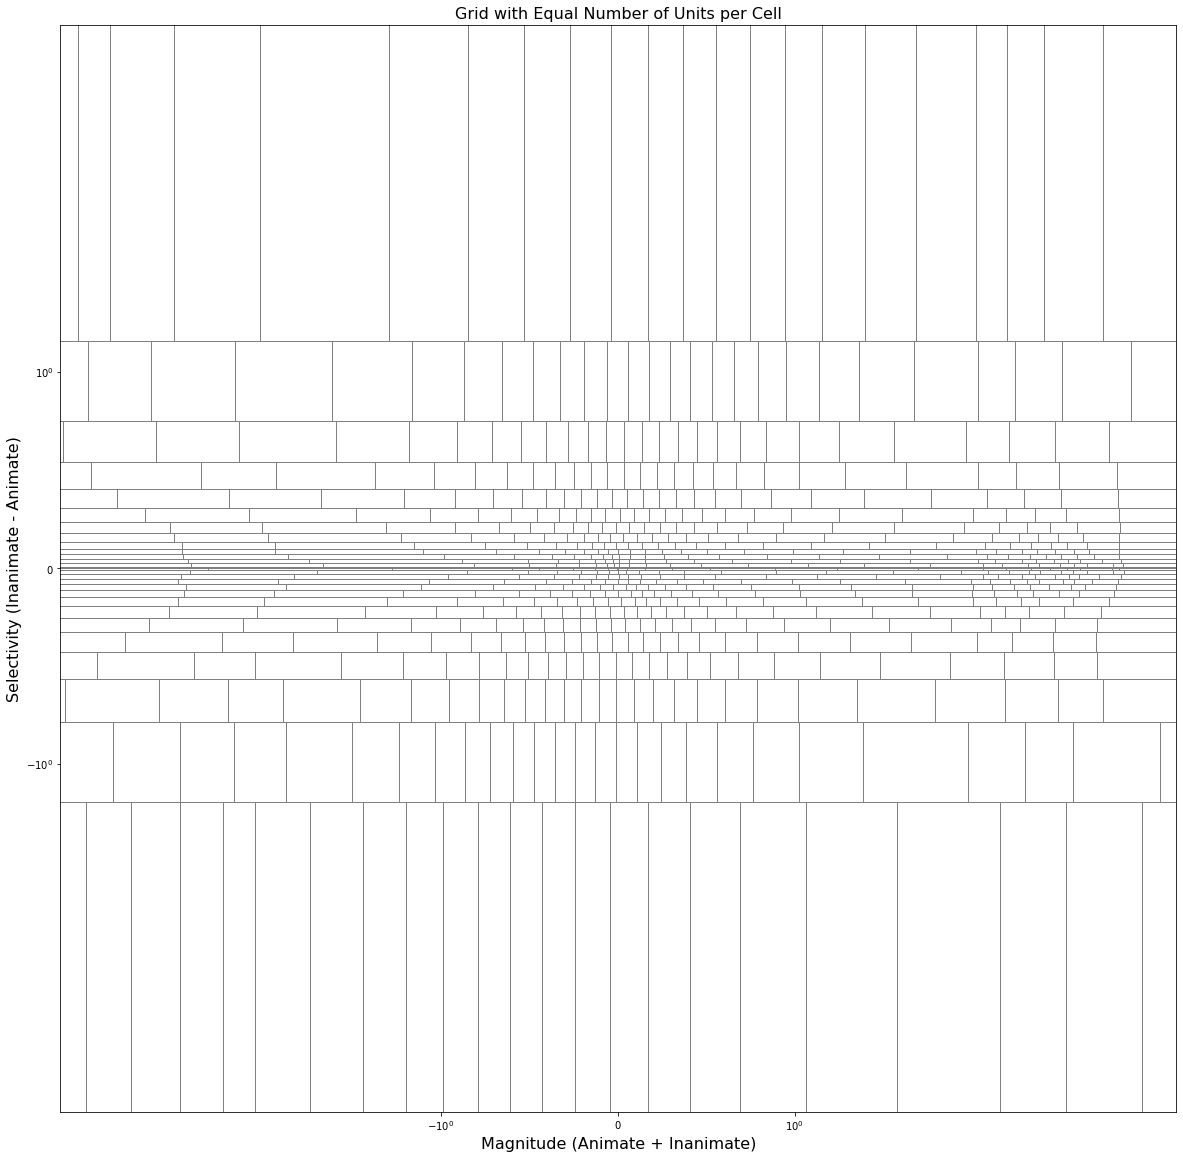

In [65]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.set_xscale('symlog')
ax.set_yscale('symlog')
cell.plot(facecolor="none", edgecolor='grey',ax=ax,aspect=None)
ax.set_title('Grid with Equal Number of Units per Cell',fontsize=16)
ax.set_xlabel('Magnitude (Animate + Inanimate)',fontsize=16)
ax.set_ylabel('Selectivity (Inanimate - Animate)',fontsize=16)
# ax.scatter(cell.iloc[[0,1,-1]]['geometry'].centroid.x,cell.iloc[[0,1,-1]]['geometry'].centroid.y)
fig.savefig(data_path+'figs/grid.png', dpi=200)

Next we create a queryable list of units in the magnitude/selectivity space

In [16]:
df = pd.DataFrame({'x':magnitude,'y':selectivity})
gdf = geopandas.GeoDataFrame(df, 
            geometry=geopandas.points_from_xy(df.x, df.y),
            crs="+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
gdf.head()

,x,y,geometry
0,-3.898015e-02,3.568990e-02,POINT (-0.039 0.036)
1,-9.385403e-02,1.483546e-01,POINT (-0.094 0.148)
2,1.526790e-02,2.614993e-02,POINT (0.015 0.026)
3,1.972559e-19,-3.116319e-19,POINT (0.000 -0.000)
4,-8.264021e-02,1.200037e-01,POINT (-0.083 0.120)


In [17]:
r_tree = gdf.sindex

### Not all cells have exactly the same number of units because we have units with duplicate activation profiles

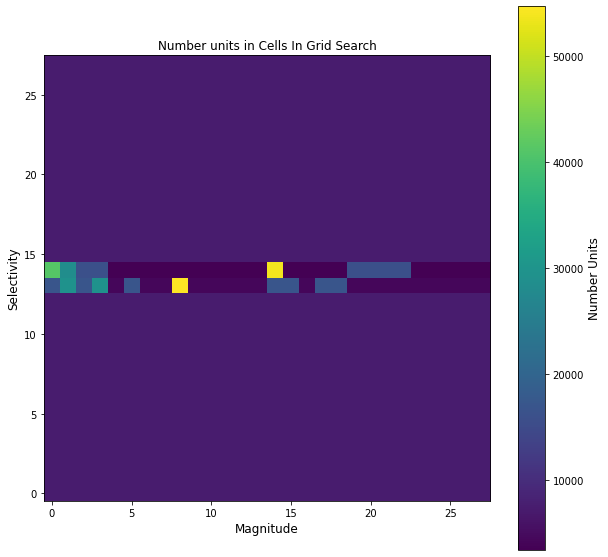

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
im = np.zeros((28,28))
for i in range(len(cell)):
    im[math.floor(i/28),(i % 28)] = len(r_tree.query(cell['geometry'][i]))
ims = ax.imshow(im,origin='lower')
ax.set_title('Number units in Cells In Grid Search',fontsize=12)
ax.set_xlabel('Magnitude',fontsize=12)
ax.set_ylabel('Selectivity',fontsize=12)
cbar = plt.colorbar(ims)
cbar.set_label('Number Units',fontsize=12)

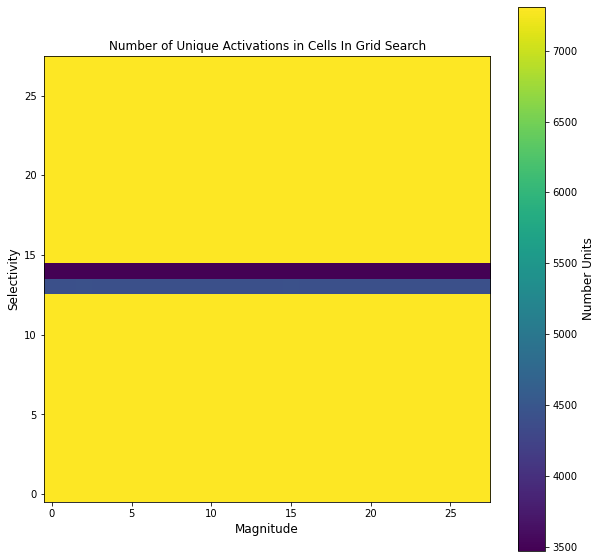

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
im = np.zeros((28,28))
for i in range(len(cell)):
    im[math.floor(i/28),(i % 28)] = len(np.unique(gdf.iloc[r_tree.query(cell['geometry'][i])][['x','y']],axis=0))
ims = ax.imshow(im,origin='lower')
ax.set_title('Number of Unique Activations in Cells In Grid Search',fontsize=12)
ax.set_xlabel('Magnitude',fontsize=12)
ax.set_ylabel('Selectivity',fontsize=12)
cbar = plt.colorbar(ims)
cbar.set_label('Number Units',fontsize=12)

# Lesioning Each Cell in Grid

In [22]:
cell_mppi = {}

# for each cell in grid
for bbx in range(len(cell)):
    start = time.time()
    
    ## R_Tree (Data Partioning Algo) --> Based on Geometry Points 
    # Query indices of units in that cell, create mask and set activations to zero
    loc_new = r_tree.query(cell['geometry'][bbx]) 
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.
    print('Cell: ', bbx, ' Units: ', len(loc_new))
    
    # Skip this cell if no units lie within it
    if len(loc_new) == 0.:
        cell_mppi[bbx] = [0,0,0]
        continue
    
    ## Don't change alpha
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None,\
                        pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

    flag = 0
    dprime = 0.
    ana_PI = ina_PI = 0
    
    # for classes ['animate','inanimate']
    for p in classes:
        im_valid_test = []
        image_list_valid = data_path+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            predicted_valid_wids.append(pprint_output(out[i]))

        # count errors
        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if p == 'animate':
            ana_PI = error 
            flag = 1
        else:
            ina_PI = error
    
    # Calculate MPPI and assign value to cell
    dprime = ana_PI - ina_PI
    cell_mppi[bbx] = [dprime, ana_PI, ina_PI]
    keras.backend.clear_session()
    gc.collect()
    del model
    print("time : ", time.time()-start)

Cell:  0  Units:  7303
animate 3 39 0.9230769230769231 0.07692307692307687
inanimate 2 39 0.9487179487179487 0.05128205128205132
time :  21.862662315368652
Cell:  1  Units:  7304
animate 24 39 0.3846153846153846 0.6153846153846154
inanimate 19 39 0.5128205128205128 0.4871794871794872
time :  18.339223861694336
Cell:  2  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.592895984649658
Cell:  3  Units:  7304
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 29 39 0.2564102564102564 0.7435897435897436
time :  18.79479193687439
Cell:  4  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  19.780174016952515
Cell:  5  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 27 39 0.3076923076923077 0.6923076923076923
time :  19.125827074050903
Cell:  6  Units:  7304
animate 34 39 0.1282051282051282 0.87

animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 35 39 0.10256410256410253 0.8974358974358975
time :  18.463070154190063
Cell:  53  Units:  7304
animate 28 39 0.28205128205128205 0.717948717948718
inanimate 30 39 0.23076923076923073 0.7692307692307693
time :  18.332969903945923
Cell:  54  Units:  7304
animate 26 39 0.33333333333333337 0.6666666666666666
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.464306831359863
Cell:  55  Units:  7304
animate 17 39 0.5641025641025641 0.4358974358974359
inanimate 26 39 0.33333333333333337 0.6666666666666666
time :  18.197988033294678
Cell:  56  Units:  7303
animate 19 39 0.5128205128205128 0.4871794871794872
inanimate 19 39 0.5128205128205128 0.4871794871794872
time :  18.19052791595459
Cell:  57  Units:  7305
animate 26 39 0.33333333333333337 0.6666666666666666
inanimate 20 39 0.4871794871794872 0.5128205128205128
time :  18.35960817337036
Cell:  58  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975


animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.4411199092865
Cell:  105  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.377793073654175
Cell:  106  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 35 39 0.10256410256410253 0.8974358974358975
time :  18.608588933944702
Cell:  107  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.57715606689453
Cell:  108  Units:  7304
animate 27 39 0.3076923076923077 0.6923076923076923
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.39496397972107
Cell:  109  Units:  7304
animate 14 39 0.641025641025641 0.35897435897435903
inanimate 30 39 0.23076923076923073 0.7692307692307693
time :  18.45090675354004
Cell:  110  Units:  7304
animate 18 39 0.5384615384615384 0.4615384615384

animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.386584997177124
Cell:  157  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.373373985290527
Cell:  158  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.558899879455566
Cell:  159  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.338072061538696
Cell:  160  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.399237871170044
Cell:  161  Units:  7304
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 35 39 0.10256410256410253 0.8974358974358975
time :  18.59892201423645
Cell:  162  Units:  7304
animate 30 39 0.23076923076923073 0.76923076923

animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.3437077999115
Cell:  209  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 35 39 0.10256410256410253 0.8974358974358975
time :  18.33029818534851
Cell:  210  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.346603870391846
Cell:  211  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.364938020706177
Cell:  212  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.473789930343628
Cell:  213  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.34881591796875
Cell:  214  Units:  7304
animate 34 39 0.1282051282051282 0.871794871794

inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.28457498550415
Cell:  261  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.285057067871094
Cell:  262  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.307111978530884
Cell:  263  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.45559310913086
Cell:  264  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.338914155960083
Cell:  265  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.307331085205078
Cell:  266  Units:  7303
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.82051282

inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.267481088638306
Cell:  313  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.394123077392578
Cell:  314  Units:  7305
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.227686882019043
Cell:  315  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.337748050689697
Cell:  316  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.311246156692505
Cell:  317  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.308820247650146
Cell:  318  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.871794

animate 22 39 0.4358974358974359 0.5641025641025641
inanimate 19 39 0.5128205128205128 0.4871794871794872
time :  18.368664026260376
Cell:  365  Units:  29594
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.359004259109497
Cell:  366  Units:  16953
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.26313304901123
Cell:  367  Units:  29496
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  18.38344407081604
Cell:  368  Units:  4411
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.346935033798218
Cell:  369  Units:  16952
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  18.395349979400635
Cell:  370  Units:  4409
animate 33 39 0.15384615384615385 0.84615

time :  18.317142009735107
Cell:  416  Units:  3473
animate 24 39 0.3846153846153846 0.6153846153846154
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.265349864959717
Cell:  417  Units:  3472
animate 12 39 0.6923076923076923 0.3076923076923077
inanimate 21 39 0.46153846153846156 0.5384615384615384
time :  18.250743865966797
Cell:  418  Units:  3473
animate 16 39 0.5897435897435898 0.41025641025641024
inanimate 22 39 0.4358974358974359 0.5641025641025641
time :  18.257715940475464
Cell:  419  Units:  3472
animate 16 39 0.5897435897435898 0.41025641025641024
inanimate 23 39 0.41025641025641024 0.5897435897435898
time :  18.265626192092896
Cell:  420  Units:  7303
animate 4 39 0.8974358974358975 0.10256410256410253
inanimate 11 39 0.717948717948718 0.28205128205128205
time :  18.383991718292236
Cell:  421  Units:  7304
animate 20 39 0.4871794871794872 0.5128205128205128
inanimate 21 39 0.46153846153846156 0.5384615384615384
time :  18.445051908493042
Cell:  422  Units: 

time :  18.260974884033203
Cell:  468  Units:  7304
animate 20 39 0.4871794871794872 0.5128205128205128
inanimate 24 39 0.3846153846153846 0.6153846153846154
time :  18.429814100265503
Cell:  469  Units:  7304
animate 16 39 0.5897435897435898 0.41025641025641024
inanimate 18 39 0.5384615384615384 0.46153846153846156
time :  18.710526943206787
Cell:  470  Units:  7304
animate 7 39 0.8205128205128205 0.17948717948717952
inanimate 18 39 0.5384615384615384 0.46153846153846156
time :  18.737549781799316
Cell:  471  Units:  7304
animate 10 39 0.7435897435897436 0.2564102564102564
inanimate 15 39 0.6153846153846154 0.3846153846153846
time :  18.407429933547974
Cell:  472  Units:  7304
animate 1 39 0.9743589743589743 0.02564102564102566
inanimate 8 39 0.7948717948717949 0.20512820512820507
time :  20.558552742004395
Cell:  473  Units:  7304
animate 1 39 0.9743589743589743 0.02564102564102566
inanimate 1 39 0.9743589743589743 0.02564102564102566
time :  22.991976022720337
Cell:  474  Units:  73

time :  18.65215277671814
Cell:  520  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.728126049041748
Cell:  521  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 30 39 0.23076923076923073 0.7692307692307693
time :  18.640827894210815
Cell:  522  Units:  7304
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.627646923065186
Cell:  523  Units:  7304
animate 27 39 0.3076923076923077 0.6923076923076923
inanimate 30 39 0.23076923076923073 0.7692307692307693
time :  18.661570072174072
Cell:  524  Units:  7304
animate 26 39 0.33333333333333337 0.6666666666666666
inanimate 26 39 0.33333333333333337 0.6666666666666666
time :  18.527228116989136
Cell:  525  Units:  7304
animate 21 39 0.46153846153846156 0.5384615384615384
inanimate 27 39 0.3076923076923077 0.6923076923076923
time :  18.62386393547058
Cell:  526  Units: 

time :  18.67459726333618
Cell:  572  Units:  7305
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.691256046295166
Cell:  573  Units:  7304
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.640876054763794
Cell:  574  Units:  7303
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 35 39 0.10256410256410253 0.8974358974358975
time :  18.543925046920776
Cell:  575  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 35 39 0.10256410256410253 0.8974358974358975
time :  18.619086027145386
Cell:  576  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  18.602777004241943
Cell:  577  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 31 39 0.20512820512820518 0.7948717948717948
time :  18.50605320930481
Cell:  578  Units:  

animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  19.825722217559814
Cell:  625  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  19.033684968948364
Cell:  626  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  21.351831912994385
Cell:  627  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  22.647149801254272
Cell:  628  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  22.722151041030884
Cell:  629  Units:  7304
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  19.12805986404419
Cell:  630  Units:  7304
animate 36 39 0.07692307692307687 0.9230769

time :  22.757913827896118
Cell:  676  Units:  7304
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  19.45050621032715
Cell:  677  Units:  7305
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  19.007763862609863
Cell:  678  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  20.811397075653076
Cell:  679  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  21.663867235183716
Cell:  680  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  22.80289602279663
Cell:  681  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  22.286760807037354
Cell:  682  Units:  7

inanimate 13 39 0.6666666666666667 0.33333333333333326
time :  25.788908004760742
Cell:  728  Units:  7303
animate 0 39 1.0 0.0
inanimate 16 39 0.5897435897435898 0.41025641025641024
time :  18.443723917007446
Cell:  729  Units:  7304
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
time :  19.572367906570435
Cell:  730  Units:  7304
animate 26 39 0.33333333333333337 0.6666666666666666
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  20.53381085395813
Cell:  731  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 34 39 0.1282051282051282 0.8717948717948718
time :  21.422607898712158
Cell:  732  Units:  7304
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  24.82188391685486
Cell:  733  Units:  7304
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
time :  20.8406760692

inanimate 24 39 0.3846153846153846 0.6153846153846154
time :  22.470550060272217
Cell:  780  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 21 39 0.46153846153846156 0.5384615384615384
time :  20.941492080688477
Cell:  781  Units:  7304
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 21 39 0.46153846153846156 0.5384615384615384
time :  22.433149814605713
Cell:  782  Units:  7304
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 21 39 0.46153846153846156 0.5384615384615384
time :  23.421294927597046
Cell:  783  Units:  7304
animate 13 39 0.6666666666666667 0.33333333333333326
inanimate 5 39 0.8717948717948718 0.1282051282051282
time :  29.1926429271698


In [23]:
with open(data_path+'cell_mppi_result_grid_784.pkl', 'wb') as handle:
     pickle.dump([cell_mppi], handle, protocol=pickle.HIGHEST_PROTOCOL)

cell_mppi_result_128.pkl
animate_MobileNetV2_image_list_test.txt
inanimate_MobileNetV2_image_list_test.txt

In [24]:
cell_mppi

{0: [-0.02564102564102555, 0.9230769230769231, 0.9487179487179487],
 1: [-0.1282051282051282, 0.3846153846153846, 0.5128205128205128],
 2: [0.0, 0.17948717948717952, 0.17948717948717952],
 3: [-0.05128205128205121, 0.20512820512820518, 0.2564102564102564],
 4: [-0.02564102564102566, 0.17948717948717952, 0.20512820512820518],
 5: [-0.17948717948717952, 0.1282051282051282, 0.3076923076923077],
 6: [-0.15384615384615385, 0.1282051282051282, 0.28205128205128205],
 7: [-0.07692307692307698, 0.1282051282051282, 0.20512820512820518],
 8: [-0.05128205128205121, 0.17948717948717952, 0.23076923076923073],
 9: [-0.07692307692307698, 0.10256410256410253, 0.17948717948717952],
 10: [-0.02564102564102566, 0.15384615384615385, 0.17948717948717952],
 11: [0.02564102564102566, 0.17948717948717952, 0.15384615384615385],
 12: [-0.02564102564102566, 0.17948717948717952, 0.20512820512820518],
 13: [0.0, 0.15384615384615385, 0.15384615384615385],
 14: [0.05128205128205132, 0.17948717948717952, 0.12820512820

In [25]:
z = np.zeros(shape=(5725552,))
## Replacing zeroes with d-prime value
for bbx in range(len(cell)):
    loc_new = r_tree.query(cell['geometry'][bbx])
    z[loc_new] = cell_mppi[bbx][0]

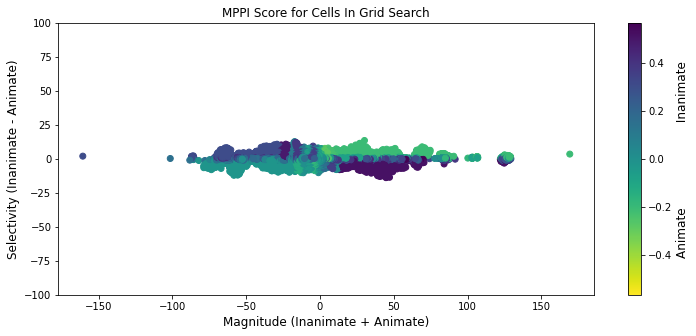

In [68]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
# ax.set_xscale('symlog')
# ax.set_yscale('symlog')
# cell.plot(vmin=min(z), vmax=max(z), facecolor="none", edgecolor='grey', ax=ax)
sc = ax.scatter(magnitude,selectivity,c=z, cmap='viridis_r',vmin=-np.max(np.abs(z)),vmax=np.max(np.abs(z)))
ax.set_ylim((-100,100))
ax.set_title('MPPI Score for Cells In Grid Search',fontsize=12)
ax.set_xlabel('Magnitude (Inanimate + Animate)',fontsize=12)
ax.set_ylabel('Selectivity (Inanimate - Animate)',fontsize=12)
cbar = plt.colorbar(sc,)
cbar.set_label('Animate                      Inanimate',fontsize=12)
fig.savefig(data_path+'figs/mppi_selectivity_magnitude_space.png', dpi=200)

# Representational Dissimilarity Score for Each Cell in Grid

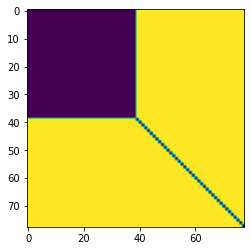

In [27]:
# Create Animate template RDM
animate_template_RDM = np.ones((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 0
for i in range(39,78):
    for j in range(39,78):
        if i == j:
            animate_template_RDM[i][j] = 0
plt.imshow(animate_template_RDM)

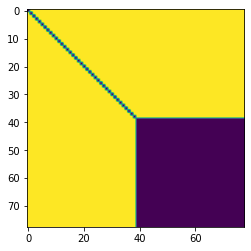

In [28]:
# Create Inanimate template RDM
inanimate_template_RDM = np.ones((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 0
for i in range(39):
    for j in range(39):
        if i == j:
            inanimate_template_RDM[i][j] = 0
plt.imshow(inanimate_template_RDM)

Collect activations for each unit in response to each animate/inanimate input

In [130]:
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet", \
                    input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax")
dprime = 0.
cluster_activations = {}
cluster_activations['animate'] = np.zeros(shape=(39,5725552))
cluster_activations['inanimate'] = np.zeros(shape=(39,5725552))
for p in classes:

    im_valid_test = []
    image_list_valid = data_path+p+'_MobileNetV2_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))

    #Cluster RDM
    flag =0      
    total = 0

    for j in range(len(im_valid_test)):
        im_temp = preprocess_image_batch([im_valid_test[j]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        print(p,j,im_valid_test[j])
        data = np.array([])

        i = 0
        for layer in model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                activations = get_activations(model,i,im_temp)
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'Logits':
                    #print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
            i += 1
        cluster_activations[p][j] = data

print(cluster_activations['animate'].shape)

animate 0 ../../data/animate/ILSVRC2012_val_00000269.JPEG
animate 1 ../../data/animate/ILSVRC2012_val_00023125.JPEG
animate 2 ../../data/animate/ILSVRC2012_val_00049291.JPEG
animate 3 ../../data/animate/ILSVRC2012_val_00016771.JPEG
animate 4 ../../data/animate/ILSVRC2012_val_00003604.JPEG
animate 5 ../../data/animate/ILSVRC2012_val_00005064.JPEG
animate 6 ../../data/animate/ILSVRC2012_val_00020432.JPEG
animate 7 ../../data/animate/ILSVRC2012_val_00007479.JPEG
animate 8 ../../data/animate/ILSVRC2012_val_00036248.JPEG
animate 9 ../../data/animate/ILSVRC2012_val_00013504.JPEG
animate 10 ../../data/animate/ILSVRC2012_val_00015251.JPEG
animate 11 ../../data/animate/ILSVRC2012_val_00022105.JPEG
animate 12 ../../data/animate/ILSVRC2012_val_00012418.JPEG
animate 13 ../../data/animate/ILSVRC2012_val_00002602.JPEG
animate 14 ../../data/animate/ILSVRC2012_val_00044573.JPEG
animate 15 ../../data/animate/ILSVRC2012_val_00024669.JPEG
animate 16 ../../data/animate/ILSVRC2012_val_00018438.JPEG
animate

In [131]:
with open(data_path+'cluster_activations.pkl', 'wb') as handle:
     pickle.dump([cluster_activations], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open(data_path+'cluster_activations.pkl', 'rb') as f:
     cluster_activations = pickle.load(f)[0]

In [32]:
#rds for each cell calculation
rds_result = {}
for bbx in range(len(cell)):
    print('Cell:', bbx)
    ## R_Tree (Data Partioning Algo) --> Based on Geometry Points 
    loc_new = r_tree.query(cell['geometry'][bbx]) 
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    dprime = 0.
    act = np.vstack((cluster_activations['animate'][:,loc_new],cluster_activations['inanimate'][:,loc_new]))
    cluster_RDM = 1 - np.corrcoef(act)    
    ana_RDS, _ = stats.kendalltau(cluster_RDM,animate_template_RDM)
    ina_RDS, _ = stats.kendalltau(cluster_RDM,inanimate_template_RDM)
    dprime = ana_RDS - ina_RDS
    
    rds_result[bbx] = [dprime, ana_RDS, ina_RDS]

Cell: 0
Cell: 1
Cell: 2
Cell: 3
Cell: 4
Cell: 5
Cell: 6
Cell: 7
Cell: 8
Cell: 9
Cell: 10
Cell: 11
Cell: 12
Cell: 13
Cell: 14
Cell: 15
Cell: 16
Cell: 17
Cell: 18
Cell: 19
Cell: 20
Cell: 21
Cell: 22
Cell: 23
Cell: 24
Cell: 25
Cell: 26
Cell: 27
Cell: 28
Cell: 29
Cell: 30
Cell: 31
Cell: 32
Cell: 33
Cell: 34
Cell: 35
Cell: 36
Cell: 37
Cell: 38
Cell: 39
Cell: 40
Cell: 41
Cell: 42
Cell: 43
Cell: 44
Cell: 45
Cell: 46
Cell: 47
Cell: 48
Cell: 49
Cell: 50
Cell: 51
Cell: 52
Cell: 53
Cell: 54
Cell: 55
Cell: 56
Cell: 57
Cell: 58
Cell: 59
Cell: 60
Cell: 61
Cell: 62
Cell: 63
Cell: 64
Cell: 65
Cell: 66
Cell: 67
Cell: 68
Cell: 69
Cell: 70
Cell: 71
Cell: 72
Cell: 73
Cell: 74
Cell: 75
Cell: 76
Cell: 77
Cell: 78
Cell: 79
Cell: 80
Cell: 81
Cell: 82
Cell: 83
Cell: 84
Cell: 85
Cell: 86
Cell: 87
Cell: 88
Cell: 89
Cell: 90
Cell: 91
Cell: 92
Cell: 93
Cell: 94
Cell: 95
Cell: 96
Cell: 97
Cell: 98
Cell: 99
Cell: 100
Cell: 101
Cell: 102
Cell: 103
Cell: 104
Cell: 105
Cell: 106
Cell: 107
Cell: 108
Cell: 109
Cell: 110


In [34]:
with open(data_path+'rds_result_grid_784.pkl', 'wb') as handle:
     pickle.dump([rds_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
z = np.zeros(shape=(5725552,))
## Replacing zeroes with d-prime value
for bbx in range(len(cell)):
    loc_new = r_tree.query(cell['geometry'][bbx])
    z[loc_new] = rds_result[bbx][0]

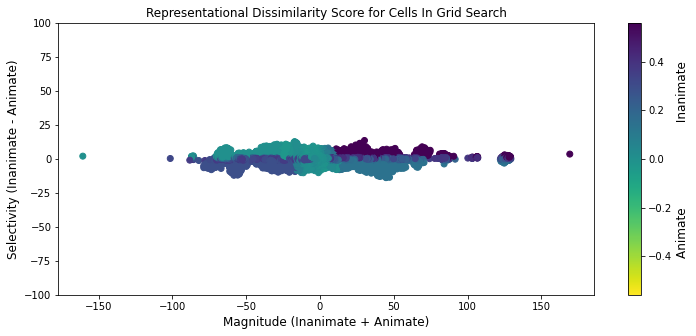

In [70]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
# ax.set_xscale('symlog')
# ax.set_yscale('symlog')
# cell.plot(vmin=min(z), vmax=max(z), facecolor="none", edgecolor='grey', ax=ax)
sc = ax.scatter(magnitude,selectivity,c=z, cmap='viridis_r',vmin=-np.max(np.abs(z)),vmax=np.max(np.abs(z)))
ax.set_ylim((-100,100))
ax.set_title('Representational Dissimilarity Score for Cells In Grid Search',fontsize=12)
ax.set_xlabel('Magnitude (Inanimate + Animate)',fontsize=12)
ax.set_ylabel('Selectivity (Inanimate - Animate)',fontsize=12)
cbar = plt.colorbar(sc,)
cbar.set_label('Animate                      Inanimate',fontsize=12)
fig.savefig(data_path+'figs/rds_selectivity_magnitude_space.png', dpi=200)

# Final Results

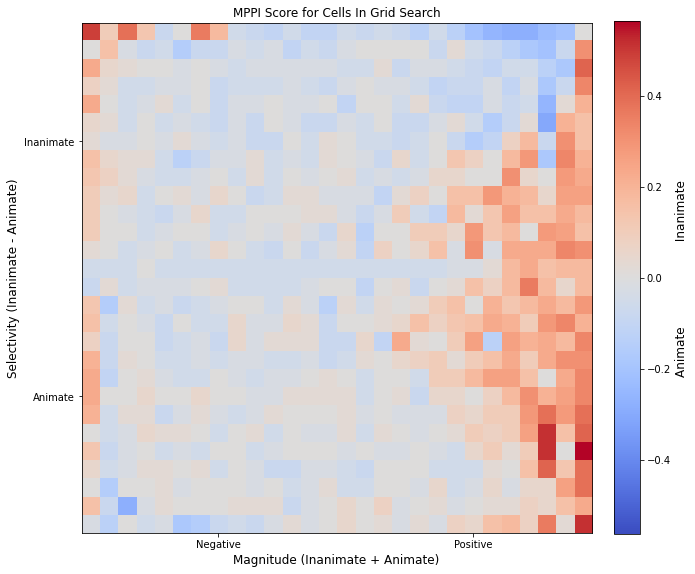

In [73]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
im = np.zeros((28,28))
for bbx in range(len(cell)):
    if bbx < 392:
        im[math.floor(bbx/28),(bbx % 28)] = cell_mppi[bbx][0]
    if bbx > 392:
        im[math.floor((bbx-1)/28),((bbx-1) % 28)] = cell_mppi[bbx][0]
ims = ax.imshow(im,origin='lower',vmin=-np.max(np.abs(im)),vmax=np.max(np.abs(im)),cmap='coolwarm')
ax.set_title('MPPI Score for Cells In Grid Search',fontsize=12)
ax.set_xlabel('Magnitude (Inanimate + Animate)',fontsize=12)
ax.set_ylabel('Selectivity (Inanimate - Animate)',fontsize=12)
ax.set_yticks([7,21])
ax.set_yticklabels(['Animate','Inanimate'])
ax.set_xticks([7,21])
ax.set_xticklabels(['Negative','Positive'])
cbar = plt.colorbar(ims,fraction=0.046, pad=0.04)
cbar.set_label('Animate                      Inanimate',fontsize=12,)
fig.savefig(data_path+'figs/mppi_grid_space.png', dpi=200)

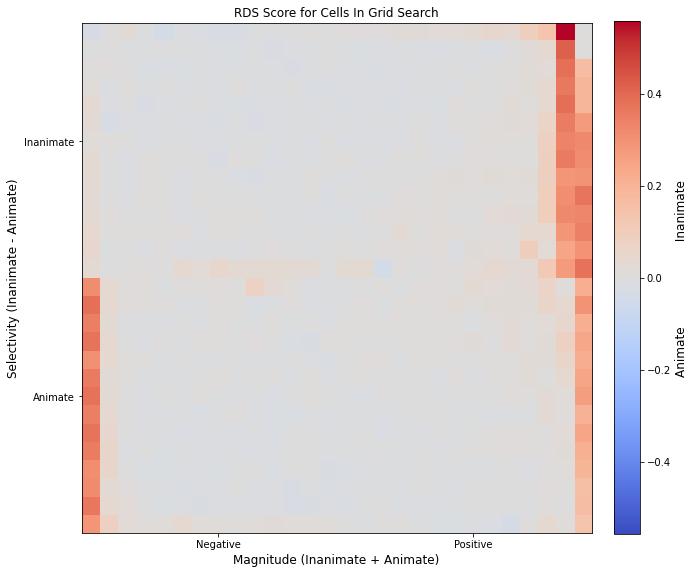

In [74]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
im = np.zeros((28,28))
for bbx in range(len(cell)):
    if bbx < 392:
        im[math.floor(bbx/28),(bbx % 28)] = rds_result[bbx][0]
    if bbx > 392:
        im[math.floor((bbx-1)/28),((bbx-1) % 28)] = rds_result[bbx][0]
ims = ax.imshow(im,origin='lower',vmin=-np.max(np.abs(im)),vmax=np.max(np.abs(im)),cmap='coolwarm')
ax.set_title('RDS Score for Cells In Grid Search',fontsize=12)
ax.set_xlabel('Magnitude (Inanimate + Animate)',fontsize=12)
ax.set_ylabel('Selectivity (Inanimate - Animate)',fontsize=12)
ax.set_yticks([7,21])
ax.set_yticklabels(['Animate','Inanimate'])
ax.set_xticks([7,21])
ax.set_xticklabels(['Negative','Positive'])
cbar = plt.colorbar(ims,fraction=0.046, pad=0.04)
cbar.set_label('Animate                      Inanimate',fontsize=12)
fig.savefig(data_path+'figs/rds_grid_space.png', dpi=200)

Text(0, 0.5, 'RDS')

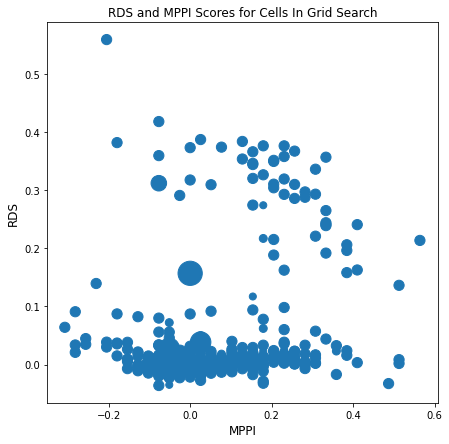

In [75]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.scatter([cell_mppi[i][0] for i in cell_mppi.keys()],
           [rds_result[i][0] for i in cell_mppi.keys()],
           s=[len(r_tree.query(cell['geometry'][i]))/70 for i in cell_mppi.keys()])
ax.set_title('RDS and MPPI Scores for Cells In Grid Search',fontsize=12)
ax.set_xlabel('MPPI',fontsize=12)
ax.set_ylabel('RDS',fontsize=12)